<a href="https://colab.research.google.com/github/PIYAL-DATTA/Multi-attack/blob/main/NSL_KDD_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting traditional intrusions (e.g. DDoS, port scans) and even “zero‑day" (previously unseen) attacks from the NSL‑KDD dataset is absolutely possible—but we will need to combine both supervised classification (for known attack types) and anomaly/novelty detection (for zero‑days).**

# Install requirements

1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.metrics import confusion_matrix, classification_report, f1_score

2. Load NSL-KDD dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("hassan06/nslkdd")

print("Path to dataset files:", path)

train_path = os.path.join(path, "KDDTrain+.txt")
test_path  = os.path.join(path, "KDDTest+.txt")

print("Path to Train dataset files:", train_path)
print("Path to Test dataset files:", test_path)

column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
    'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','label','difficulty_level'
]

train_df = pd.read_csv(train_path, names=column_names)
test_df = pd.read_csv(test_path, names=column_names)

Path to dataset files: /kaggle/input/nslkdd
Path to Train dataset files: /kaggle/input/nslkdd/KDDTrain+.txt
Path to Test dataset files: /kaggle/input/nslkdd/KDDTest+.txt


3. Encode categorical features

In [ ]:
print(len(train_df.columns))

43


In [ ]:
categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {}
for col in categorical_cols:
    enc = LabelEncoder()
    train_df[col] = enc.fit_transform(train_df[col])
    test_df[col] = enc.transform(test_df[col])
    encoders[col] = enc

4. Encode labels into categories (normal, DoS, Probe, etc.)

In [ ]:
train_df['label'].value_counts()

,count
label,
normal,67343
neptune,41214
satan,3633
ipsweep,3599
portsweep,2931
smurf,2646
nmap,1493
back,956
teardrop,892


In [ ]:
def map_attack(label):
    dos = ['back','land','neptune','pod','smurf','teardrop','mailbomb','apache2','processtable','udpstorm']
    probe = ['satan','ipsweep','nmap','portsweep','mscan','saint']
    r2l = ['guess_passwd','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']
    u2r = ['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']

    # if label == 'normal': return 0 # 'normal'
    # elif label in dos: return 1 # 'DoS'
    # elif label in probe: return 2 # 'Probe'
    # elif label in r2l: return 3 # 'R2L'
    # elif label in u2r: return 4 # 'U2R'
    # else: return 5 # 'unknown'

    if label == 'normal': return 0 # 'normal'
    elif label in dos: return 1 # 'DoS'
    elif label in probe: return 2 # 'Probe'
    elif label in r2l: return 2 # 'R2L'
    elif label in u2r: return 2 # 'U2R'
    else: return 2 # 'unknown'
# 2 represent BotNet attack.
# 'Probe' Early stage, 'R2L' and 'U2R' attack phase

train_df['attack_class'] = train_df['label'].apply(map_attack)
test_df['attack_class']  = test_df['label'].apply(map_attack)

In [ ]:
train_df['attack_class'].value_counts()

,count
attack_class,
0,67343
1,45927
2,12703


In [ ]:
test_df['attack_class'].value_counts()

,count
attack_class,
0,9711
1,7458
2,5375


5. Prepare data for supervised classification

In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)

# # 1. Handle the target variable properly
# y_encoded = df['attack_class']  # Already encoded as numbers 0-5 from your map_attack function
# num_classes = len(y_encoded.unique())

# # 2. Address class imbalance - use class weights
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
# class_weights = dict(enumerate(class_weights))

# # 3. Alternative feature processing (better than arbitrary reshaping)
# # Normalize features
# scaler = MinMaxScaler()
# X = df.drop(columns=['label','attack_class'])
# X_scaled = scaler.fit_transform(X) # Already 2D (n_samples, n_features)

# X_reshaped = X_scaled.reshape(-1, 6, 7, 1)
# # Plot as an image
# plt.imshow(X_scaled[0], cmap='viridis')
# plt.colorbar()
# plt.title("Tabular Data as Artificial Image")
# plt.show()

# Image

In [ ]:
# Already done in your code
normal_data = df[df['attack_class'] == 0].copy()
X_normal = normal_data.drop(columns=['attack_class', 'label'])
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_normal_reshaped = X_normal_scaled.reshape(-1, 6, 7, 1)  # Your chosen shape

In [ ]:
attack_data = df[df['attack_class'].isin([1, 2])].copy()
X_attack = attack_data.drop(columns=['attack_class', 'label'])
X_attack_scaled = scaler.transform(X_attack)  # Use the same scaler as normal data
X_attack_reshaped = X_attack_scaled.reshape(-1, 6, 7, 1)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

# Encoder
input_img = Input(shape=(6, 7, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((1, 1), padding='same')(x)  # No downsampling (optional)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((1, 1), padding='same')(x)  # No downsampling

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((1, 1))(x)  # No upsampling
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((1, 1))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(
    X_normal_reshaped, X_normal_reshaped,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_split=0.1  # Optional for monitoring
)

Epoch 1/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.7582 - val_loss: 0.6649
Epoch 2/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.7683 - val_loss: 0.6642
Epoch 3/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.7891 - val_loss: 0.6640
Epoch 4/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.7823 - val_loss: 0.6640
Epoch 5/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.7931 - val_loss: 0.6638
Epoch 6/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.8899 - val_loss: 0.6638
Epoch 7/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.8088 - val_loss: 0.6637
Epoch 8/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.7659 - val_loss: 0.6637
Epoch 9/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.7699 - val_loss: 0.6637
Epoch 10/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.7617 - val_loss: 0.6653
Epoch 11/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.8384 - val_loss: 0.6642
Epoch 12/30
2168/21

In [ ]:
def get_reconstruction_errors(model, data):
    reconstructions = model.predict(data)
    mse = np.mean(np.square(data - reconstructions), axis=(1, 2, 3))
    return mse

# Errors for normal and attack data
normal_errors = get_reconstruction_errors(autoencoder, X_normal_reshaped)
attack_errors = get_reconstruction_errors(autoencoder, X_attack_reshaped)

2408/2408 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2234/2234 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [ ]:
threshold = np.percentile(normal_errors, 85)  # Adjust percentile as needed

In [ ]:
# Predict anomalies (1=attack, 0=normal)
y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(attack_errors))])
y_pred = np.concatenate([normal_errors, attack_errors]) > threshold

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

Confusion Matrix:
[[65496 11558]
 [ 4091 67372]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9412    0.8500    0.8933     77054
         1.0     0.8536    0.9428    0.8959     71463

    accuracy                         0.8946    148517
   macro avg     0.8974    0.8964    0.8946    148517
weighted avg     0.8990    0.8946    0.8946    148517



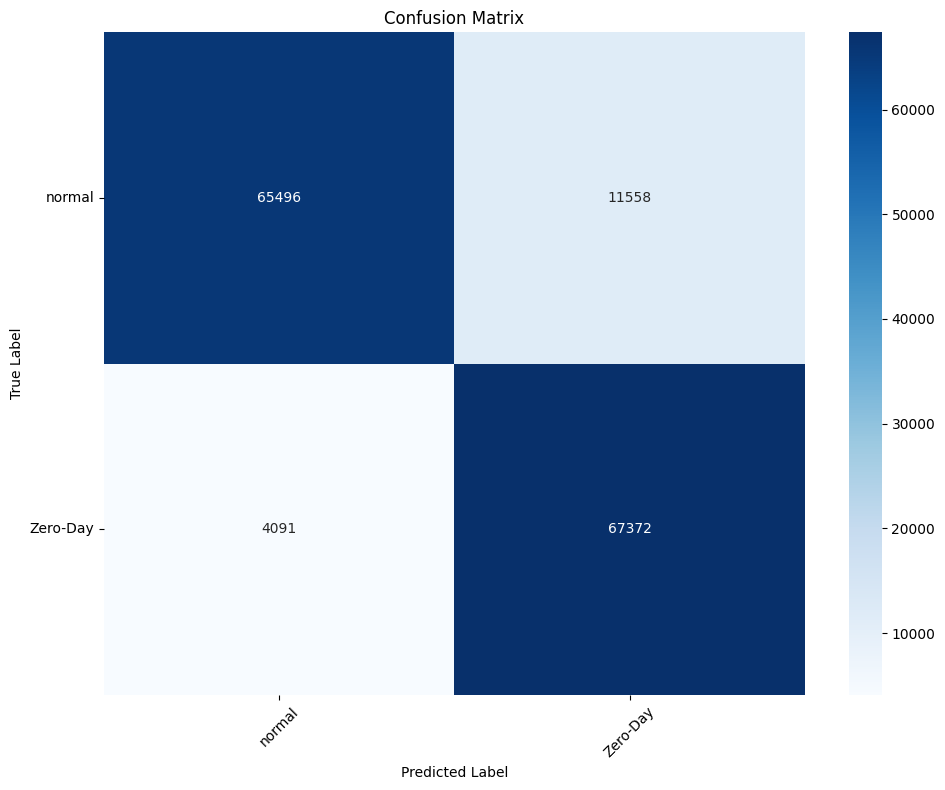

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels (based on your mapping function)
class_names = [
    'normal',       # 0
    'Zero-Day',          # 1
]

# 4. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

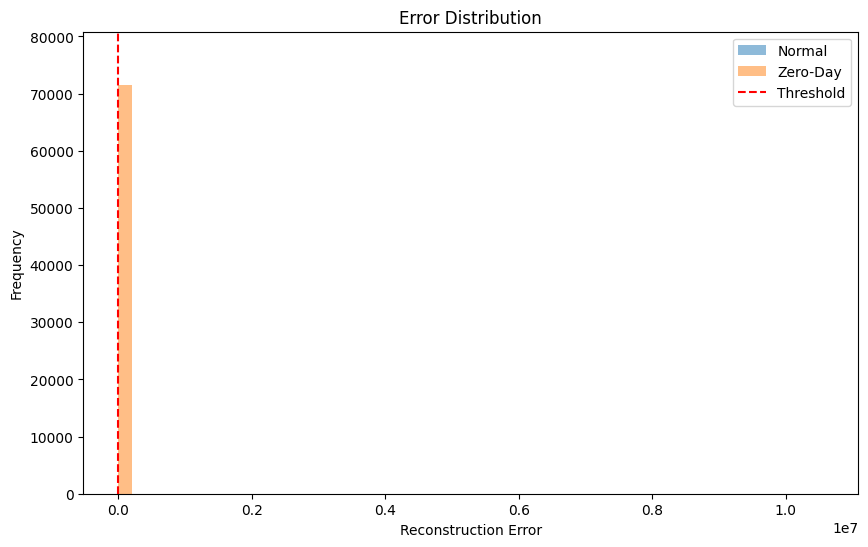

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
plt.hist(attack_errors, bins=50, alpha=0.5, label='Zero-Day')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

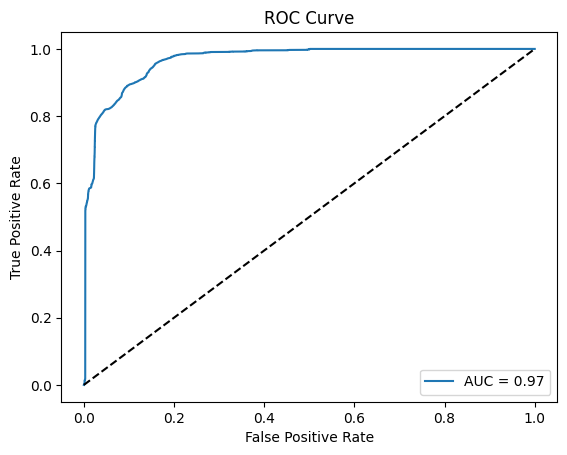

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, np.concatenate([normal_errors, attack_errors]))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Raw Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Split into normal (class 0) and attack (classes 1, 2)
normal_data = df[df['attack_class'] == 0].copy()
attack_data = df[df['attack_class'].isin([1, 2])].copy()

# Drop labels and non-feature columns
X_normal = normal_data.drop(columns=['attack_class', 'label'])  # Adjust columns as needed
X_attack = attack_data.drop(columns=['attack_class', 'label'])

# Standardize data (fit only on normal data)
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_attack_scaled = scaler.transform(X_attack)  # Use same scaler

In [ ]:
# Reshape to (n_samples, n_features, 1)
X_normal_reshaped = X_normal_scaled.reshape(X_normal_scaled.shape[0], X_normal_scaled.shape[1], 1)
X_attack_reshaped = X_attack_scaled.reshape(X_attack_scaled.shape[0], X_attack_scaled.shape[1], 1)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape

input_dim = X_normal_scaled.shape[1]  # Should be 42

# Encoder
input_layer = Input(shape=(X_normal_scaled.shape[1], 1))
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

# Decoder
x = Conv1D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)

x = x[:, :input_dim, :]  # Truncate to original length

decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 42, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 22, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 42, 1)          │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,937 (62.25 KB)

 Trainable params: 15,937 (62.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    X_normal_reshaped, X_normal_reshaped,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_split=0.1  # Optional
)

Epoch 1/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.8418 - val_loss: 0.6695
Epoch 2/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.7227 - val_loss: 0.6689
Epoch 3/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.8382 - val_loss: 0.6661
Epoch 4/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - loss: 0.8004 - val_loss: 0.6653
Epoch 5/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.7302 - val_loss: 0.6653
Epoch 6/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.7414 - val_loss: 0.6647
Epoch 7/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.8140 - val_loss: 0.6647
Epoch 8/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.7730 - val_loss: 0.6652
Epoch 9/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.9469 - val_loss: 0.6644
Epoch 10/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 0.7061 - val_loss: 0.6648
Epoch 11/30
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.7642 - val_loss: 0.6643
Epoch 12

In [ ]:
def get_reconstruction_errors(model, data):
    reconstructions = model.predict(data)
    mse = np.mean(np.square(data - reconstructions), axis=1)  # MSE per sample
    return mse

# Errors for normal and attack data
normal_errors = get_reconstruction_errors(autoencoder, X_normal_reshaped)
attack_errors = get_reconstruction_errors(autoencoder, X_attack_reshaped)

2408/2408 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2234/2234 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [ ]:
threshold = np.percentile(normal_errors, 85)  # Adjust as needed

In [ ]:
# True labels (0=normal, 1=attack)
y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(attack_errors))])

# Predicted labels (0=normal, 1=attack)
y_pred = np.concatenate([normal_errors, attack_errors]) > threshold

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))
print("\nAUC-ROC:", roc_auc_score(y_true, np.concatenate([normal_errors, attack_errors])))

Confusion Matrix:
[[65496 11558]
 [ 4093 67370]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9412    0.8500    0.8933     77054
         1.0     0.8536    0.9427    0.8959     71463

    accuracy                         0.8946    148517
   macro avg     0.8974    0.8964    0.8946    148517
weighted avg     0.8990    0.8946    0.8946    148517


AUC-ROC: 0.9668856144937953


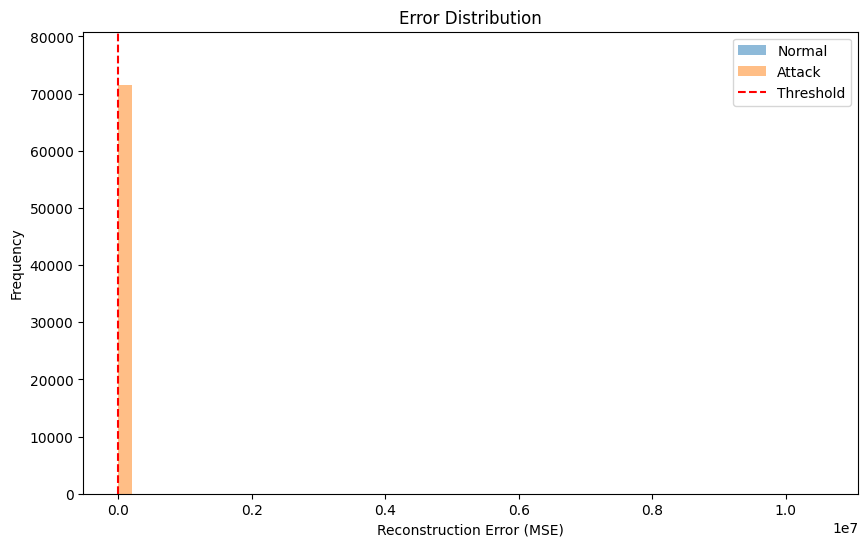

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
plt.hist(attack_errors, bins=50, alpha=0.5, label='Attack')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

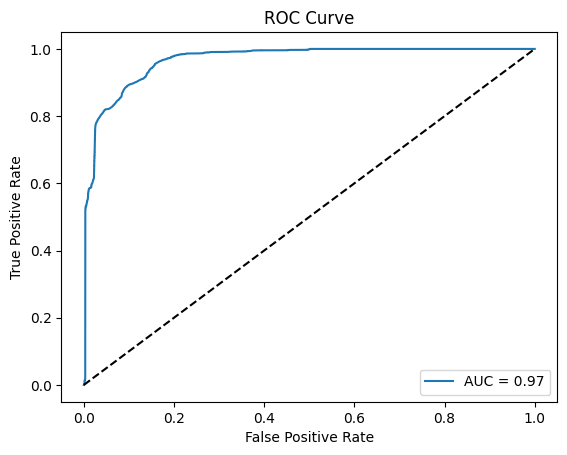

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, np.concatenate([normal_errors, attack_errors]))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_true, np.concatenate([normal_errors, attack_errors])):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# # Assuming df is your DataFrame
# class_0_data = df[df['attack_class'] == 0].copy()

# from sklearn.preprocessing import StandardScaler

# # Drop non-feature columns (like 'attack_class') and keep only features
# X_class_0 = class_0_data.drop(columns=['attack_class', 'label'])

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_class_0)

# # Reshape for CNN (example: assuming 1D features -> reshape to 2D "images")
# # You may need to adjust dimensions based on your data.
# # For example, if each sample has N features, reshape to (N, 1, 1) for a "fake" image.
# # n_samples = X_scaled.shape[0]
# # n_features = X_scaled.shape[1]

# # Reshape to (samples, height, width, channels)
# # Example: Treat each sample as a 1D "image" with 1 channel
# X_reshaped = X_scaled.reshape(-1, 6, 7, 1)

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

# # Encoder
# input_img = Input(shape=(6, 7, 1))
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((1, 1), padding='same')(x)  # No downsampling (optional)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((1, 1), padding='same')(x)  # No downsampling

# # Decoder
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((1, 1))(x)  # No upsampling
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((1, 1))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

# # Train the autoencoder
# autoencoder.fit(
#     X_reshaped, X_reshaped,  # Autoencoders learn to reconstruct input
#     epochs=15,
#     batch_size=32,
#     shuffle=True
# )